In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import os
import time
from IPython import display
from tensorflow import keras
from tensorflow.keras import layers

In [2]:
(X_train, y_train), (_,_) = tf.keras.datasets.fashion_mnist.load_data()

In [3]:
X_train.shape, y_train.shape

((60000, 28, 28), (60000,))

54134
3


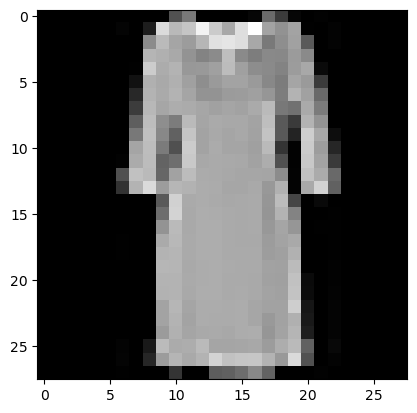

In [4]:
#randomly print y , position in the sample dataset and which output label
i = np.random.randint(0,60000)
print(i)
print(y_train[i])
#visualize the image
plt.imshow(X_train[i], cmap= 'gray')

In [5]:
#make 4d to compatible with keras train
X_train = X_train.reshape(X_train.shape[0], 28, 28, 1).astype('float32')

In [6]:
X_train.shape

(60000, 28, 28, 1)

In [7]:
#normalize the data
X_train = (X_train -127.5) / 127.5

In [8]:
buffer_size = 60000
batch_size = 256
buffer_size / batch_size

234.375

In [9]:
#the training dataset is in numpy format
# we need to convert in to tensorflow format to train the neural network
# train the network with batch of 234 images 
X_train = tf.data.Dataset.from_tensor_slices(X_train).shuffle(buffer_size).batch(batch_size)

In [10]:
type(X_train)

tensorflow.python.data.ops.batch_op._BatchDataset

# Building the Generator

In [11]:
def build_generator():
    network = tf.keras.Sequential()
    
    # 7*7*256 units of neurons will be used in the neural network input layer
    #we will not use bias because we are not training network to classify
    # input_shape = 100 means 100 neurons will connect to the input layer as random variable input with 7*7*256 neurons
    # in this way 100 random numbers will be input to the network
    #explicitly define the input layer shape to avoid **kwargs error
    network.add(layers.Input(shape=(100,)))
    network.add(layers.Dense(units = 7*7*256, use_bias = False, ))
    #batchnormalization will apply normalization in the layers also
    network.add(layers.BatchNormalization())
    network.add(layers.LeakyReLU())
    network.add(layers.Reshape((7,7,256)))
    
    #hidden layers
    network.add(layers.Conv2DTranspose(filters = 128, kernel_size = (5,5), padding = 'same', use_bias = False))
    network.add(layers.BatchNormalization())
    network.add(layers.LeakyReLU())
    
    # upsample layer 14*14*64
    network.add(layers.Conv2DTranspose(filters = 64, kernel_size = (5,5), padding = 'same', strides = (2,2), use_bias = False))
    network.add(layers.BatchNormalization())
    network.add(layers.LeakyReLU())    
    
    #28*28*1
    # as we have normalized the pixels in [-1,1] we can not use sigmoid, so used tanh
    network.add(layers.Conv2DTranspose(filters = 1, kernel_size = (5,5), padding = 'same', strides = (2,2), use_bias = True, activation = 'tanh'))
    network.summary()
    return network

In [12]:
generator = build_generator()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 12544)          │     1,254,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 12544)          │        50,176 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 12544)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 7, 7, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (None, 7, 7, 128)      │       819,200 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 7, 7, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (None, 14, 14, 64)     │       204,800 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 14, 14, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_2 (LeakyReLU)       │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_2              │ (None, 28, 28, 1)      │         1,601 │
│ (Conv2DTranspose)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,330,945 (8.89 MB)

 Trainable params: 2,305,473 (8.79 MB)

 Non-trainable params: 25,472 (99.50 KB)

In [13]:
noise = tf.random.normal([1,100])
noise

<tf.Tensor: shape=(1, 100), dtype=float32, numpy=
array([[-0.8795551 ,  2.292707  ,  0.46510187, -1.7466508 , -0.92846656,
         0.5034796 , -0.7591899 , -0.7534931 , -1.3341596 ,  0.18445665,
        -1.1503363 ,  1.3243762 , -0.48270196,  0.01040623,  0.54246444,
        -0.12722173, -1.387411  ,  1.7619396 ,  0.27203098,  0.40913147,
         0.43832096, -2.321455  , -1.2851974 , -1.1416864 , -0.1832338 ,
        -1.0449133 , -0.25970277,  0.10577276,  0.42270884, -0.46040958,
         0.99969584, -0.2770135 , -1.0624776 , -0.21643342,  0.27526534,
         0.05889869, -0.54695445, -0.88452244,  0.5224434 ,  0.967333  ,
        -0.32337976, -0.40949923, -0.37552974, -0.10032524,  1.2964841 ,
        -0.6014208 ,  0.8324804 , -0.62761754, -0.44434676,  0.05495827,
        -0.4867917 ,  1.3322848 ,  1.1163312 , -0.05748818, -1.8250139 ,
         0.94675434,  1.1729019 , -0.6347283 ,  0.20563926, -0.15928434,
        -1.3770064 ,  0.23867968,  0.5126068 ,  0.0062195 , -1.3170533 ,
 

In [14]:
generator.layers[0].input

<KerasTensor shape=(None, 100), dtype=float32, sparse=False, name=keras_tensor>

In [15]:
generated_image = generator(noise, training = False)

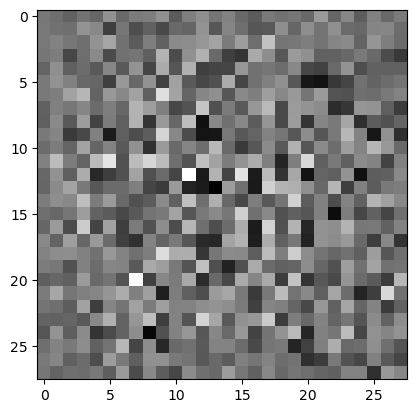

In [16]:
#we will manually access the shape to avoid error
plt.imshow(generated_image[0, :, :, 0], cmap = 'gray')

# Building the Discriminator

In [17]:
def build_discriminator():
    network = tf.keras.Sequential()
    
    # 14*14*64
    network.add(layers.Input(shape=[28,28,1]))
    network.add(layers.Conv2D(filters = 64, strides = (2,2), kernel_size = (5,5), padding = 'same'))
    network.add(layers.LeakyReLU())
    network.add(layers.Dropout(0.3))
    
    # 7*7*128
    network.add(layers.Conv2D(filters = 128, strides = (2,2), kernel_size = (5,5), padding = 'same'))
    network.add(layers.LeakyReLU())
    network.add(layers.Dropout(0.3)) 
    
    #convert to vector 
    network.add(layers.Flatten())
    network.add(layers.Dense(1))
    network.summary()
    return network

In [18]:
discriminator = build_discriminator()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 14, 14, 64)     │         1,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_3 (LeakyReLU)       │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 7, 7, 128)      │       204,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_4 (LeakyReLU)       │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 6272)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │         6,273 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 212,865 (831.50 KB)

 Trainable params: 212,865 (831.50 KB)

 Non-trainable params: 0 (0.00 B)

# Wasserstein Loss

$$L = \mathbb{E}_{\tilde{x} \sim \mathbb{P}_g} [D(\tilde{x})] - \mathbb{E}_{x \sim \mathbb{P}_r} [D(x)] + \lambda \mathbb{E}_{\hat{x} \sim \mathbb{P}_{\hat{x}}} \left[ \left( \|\nabla_{\hat{x}} D(\hat{x})\|_2 - 1 \right)^2 \right]$$


Steps to calculate the gradient penalty:
1. Calculate the interpolated image from the real and fake image ((real_image * epsilon) + fake_image * (1 -epsilon)))
2. Calculate the gradient of the discriminator output relative to the interpolated image. After, we calculate the gradient norm
3. The penalty is calculated as an average of the square of (norm - 1), as we want the norm to be close to one

In [19]:
def loss_generator(fake_output):
    g_loss = -1. * tf.math.reduce_mean(fake_output)
    return g_loss

In [20]:
def loss_discriminator(real_output, fake_output, gradient_penalty):
    c_lambda = 10.0
    d_loss = tf.math.reduce_mean(fake_output) - tf.math.reduce_mean(real_output) + c_lambda * gradient_penalty
    return d_loss

In [21]:
@tf.function
def gradient_penalty(real, fake, epsilon):
    interpolated_images = real * epsilon + fake*(1-epsilon) # step 1
    with tf.GradientTape() as tape:
        tape.watch(interpolated_images)
        scores = discriminator(interpolated_images)[0]
    gradient = tape.gradient(scores, interpolated_images)[0]
    gradient_norm = tf.norm(gradient)
    gp = tf.math.reduce_mean((gradient_norm - 1)**2) # step 3
    return gp

In [22]:
#beta hyperparameters are decay rates helps the gradient to converge 
generator_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1 = 0.5, beta_2 = 0.9 )
discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1 = 0.5, beta_2 = 0.9 )

In [23]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, 'checkpoints')
checkpoint = tf.train.Checkpoint(generator_optimizer = generator_optimizer,
                                 discriminator_optimizer = discriminator_optimizer,
                                 generator = generator,
                                 discriminator = discriminator)

# Training the Model

In [24]:
epochs = 40
noise_dim = 100
number_of_images = 16
seed = tf.random.normal([number_of_images, noise_dim])

In [25]:
def training_step(images):
    noise = tf.random.normal([batch_size, noise_dim])
    discriminator_extra_steps = 3 #ncritic = 3 here
    for i in range(discriminator_extra_steps):
        with tf.GradientTape() as d_tape:
            generated_images = generator(noise, training = True)
            real_output = discriminator(images, training = True)
            fake_output = discriminator(generated_images, training = True)
            epsilon = tf.random.normal([batch_size, 1,1,1], 0.0, 1.0)
            gp = gradient_penalty(images, generated_images, epsilon)
            
            d_loss = loss_discriminator(real_output, fake_output, gp)
        discriminator_gradients = d_tape.gradient(d_loss, discriminator.trainable_variables)
        discriminator_optimizer.apply_gradients(zip(discriminator_gradients, discriminator.trainable_variables))
    with tf.GradientTape() as g_tape:
        generated_images = generator(noise, training = True)
        fake_output = discriminator(generated_images, training = True)
        g_loss = loss_generator(fake_output)
    generator_gradients = g_tape.gradient(g_loss, generator.trainable_variables)
    generator_optimizer.apply_gradients(zip(generator_gradients, generator.trainable_variables))

In [26]:
def create_and_save_images(model, epoch, test_input):
    preds = model(test_input, training = False)
    fig = plt.figure(figsize = (4,4))
    for i in range(preds.shape[0]):
        plt.subplot(4,4, i+1)
        plt.imshow(preds[i, :, :, 0] * 127.5+127.5, cmap = 'gray')
        plt.axis('off')
    plt.savefig('img_epoch_{:04d}'.format(epoch))
    plt.show()

In [27]:
def train(dataset, epochs):
    for epoch in range(epochs):
        initial = time.time()
        for img_batch in dataset:
            if len(img_batch) == batch_size:
                training_step(img_batch)
        create_and_save_images(generator, epoch+1, seed)
        if (epoch + 1) % 10 == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)
        print("Time taken to process epoch {} was  {} seconds".format(epoch+1, time.time() - initial))
    create_and_save_images(generator, epochs, seed)
    generator.save('WGAN_mnist_fashion_model.keras')

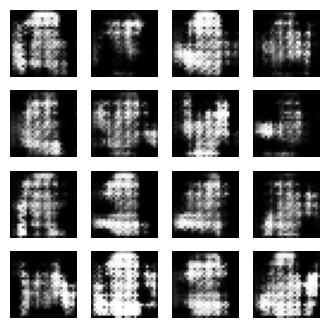

Time taken to process epoch 1 was  332.71413683891296 seconds


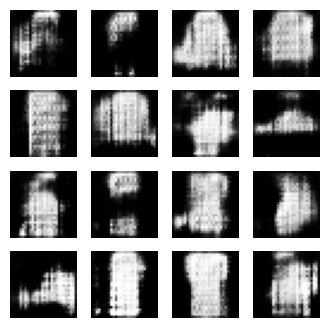

Time taken to process epoch 2 was  335.5550262928009 seconds


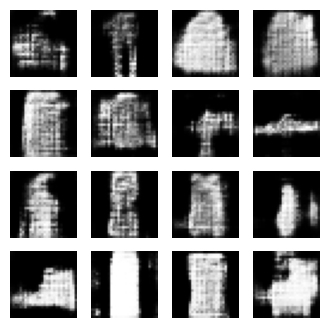

Time taken to process epoch 3 was  335.3513820171356 seconds


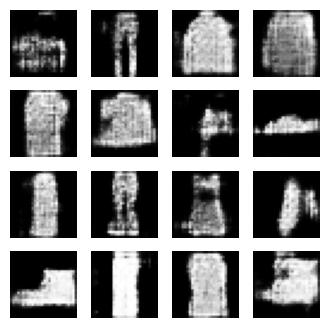

Time taken to process epoch 4 was  332.44644474983215 seconds


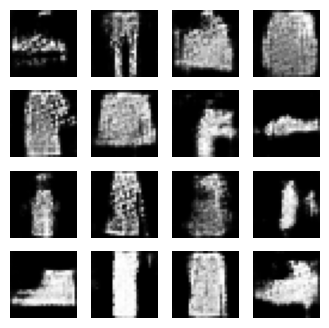

Time taken to process epoch 5 was  341.23171281814575 seconds


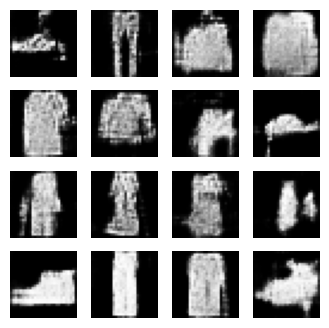

Time taken to process epoch 6 was  347.9547712802887 seconds


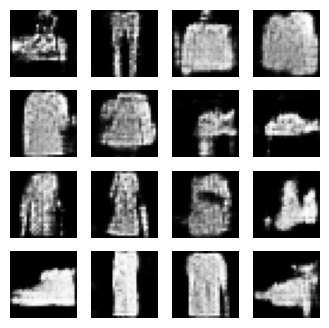

Time taken to process epoch 7 was  347.1700837612152 seconds


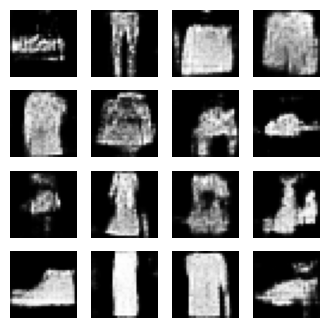

Time taken to process epoch 8 was  332.595534324646 seconds


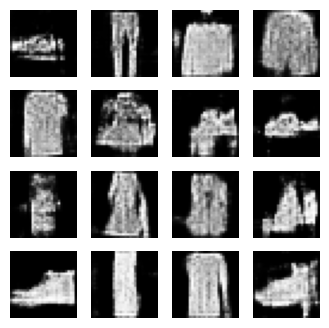

Time taken to process epoch 9 was  367.97994327545166 seconds


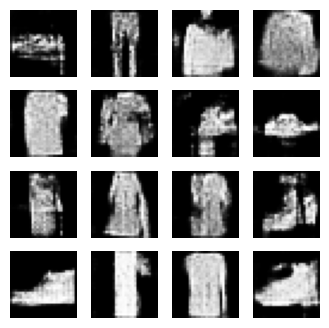

Time taken to process epoch 10 was  392.7290127277374 seconds


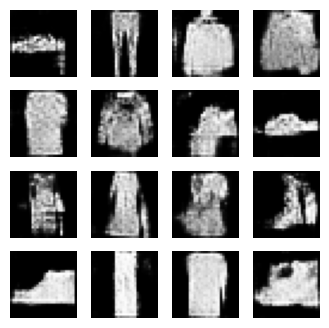

Time taken to process epoch 11 was  392.98990058898926 seconds


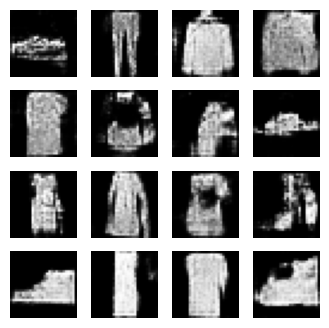

Time taken to process epoch 12 was  393.00027298927307 seconds


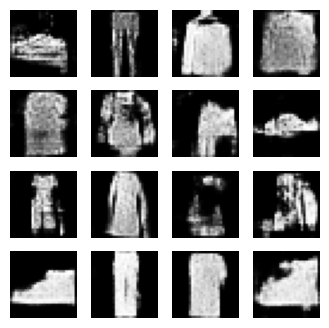

Time taken to process epoch 13 was  393.55031299591064 seconds


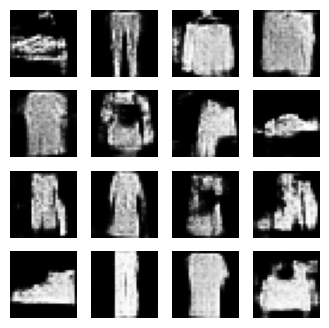

Time taken to process epoch 14 was  399.99229550361633 seconds


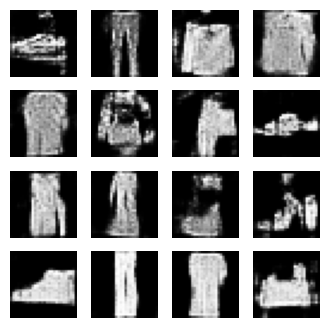

Time taken to process epoch 15 was  396.14273738861084 seconds


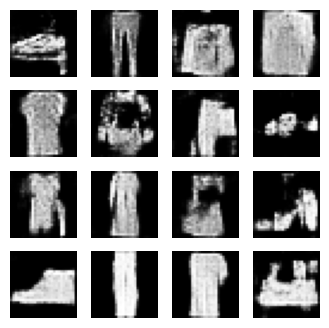

Time taken to process epoch 16 was  403.08647775650024 seconds


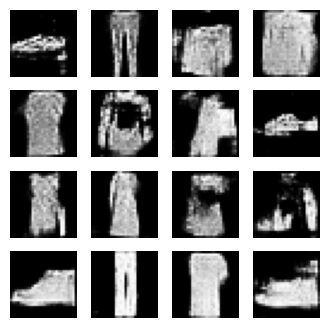

Time taken to process epoch 17 was  397.69215297698975 seconds


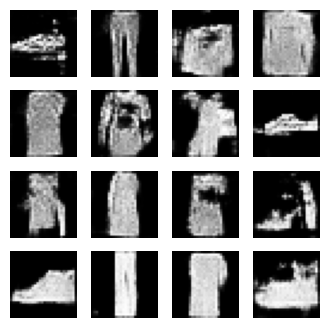

Time taken to process epoch 18 was  393.0099296569824 seconds


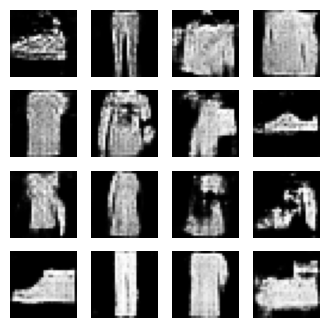

Time taken to process epoch 19 was  392.9897656440735 seconds


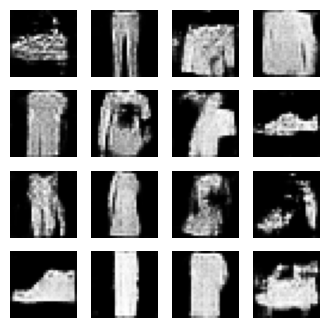

Time taken to process epoch 20 was  393.83395075798035 seconds


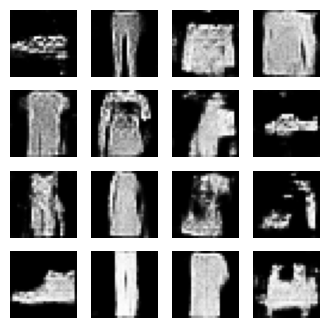

Time taken to process epoch 21 was  393.41446447372437 seconds


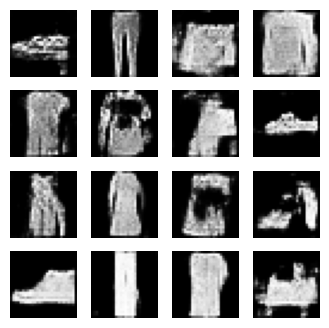

Time taken to process epoch 22 was  393.3888945579529 seconds


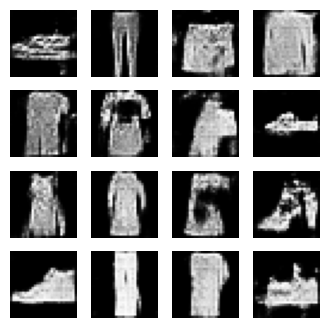

Time taken to process epoch 23 was  393.7662351131439 seconds


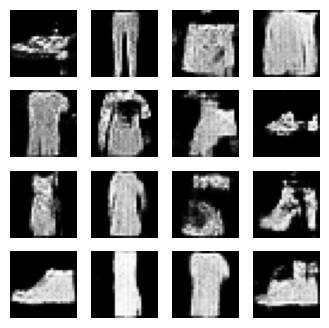

Time taken to process epoch 24 was  392.3340675830841 seconds


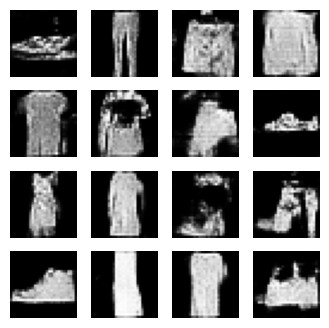

Time taken to process epoch 25 was  394.1082434654236 seconds


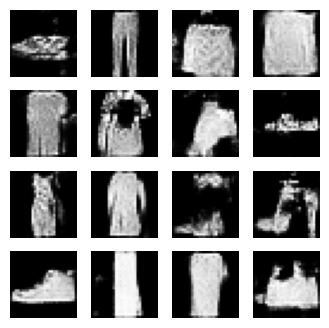

Time taken to process epoch 26 was  394.54775404930115 seconds


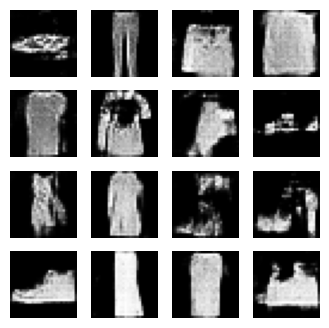

Time taken to process epoch 27 was  392.64308762550354 seconds


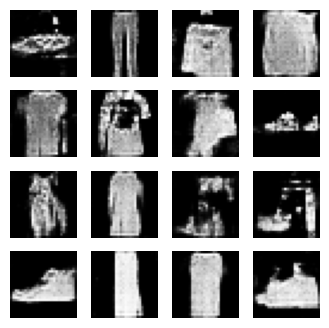

Time taken to process epoch 28 was  393.29270696640015 seconds


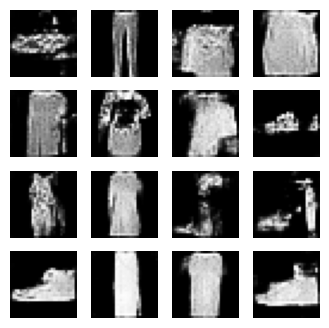

Time taken to process epoch 29 was  392.5217468738556 seconds


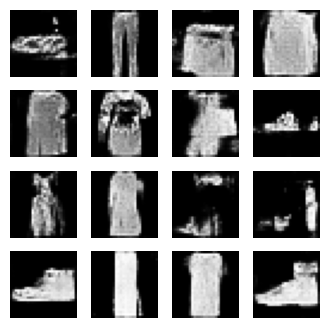

Time taken to process epoch 30 was  392.6461281776428 seconds


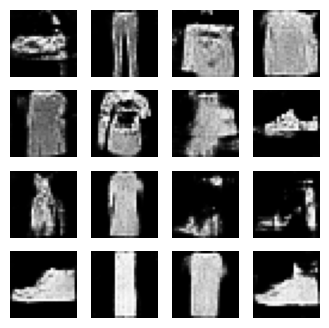

Time taken to process epoch 31 was  393.2955787181854 seconds


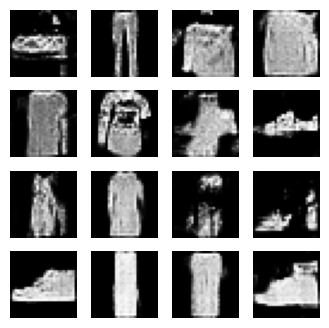

Time taken to process epoch 32 was  393.32353711128235 seconds


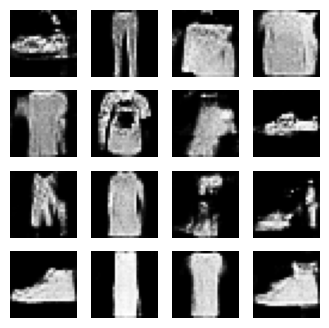

Time taken to process epoch 33 was  392.9039828777313 seconds


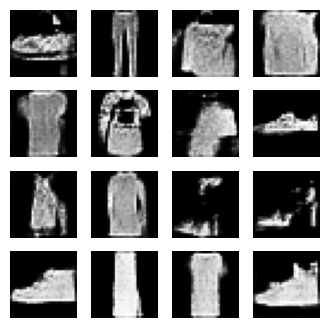

Time taken to process epoch 34 was  393.98814606666565 seconds


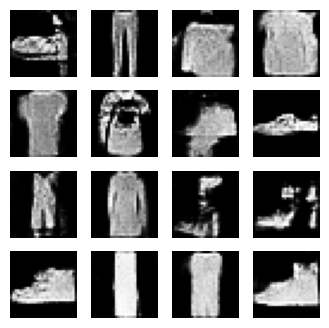

Time taken to process epoch 35 was  393.8242802619934 seconds


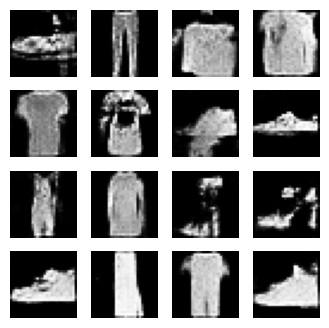

Time taken to process epoch 36 was  391.72978234291077 seconds


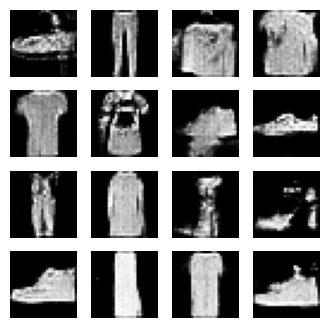

Time taken to process epoch 37 was  393.1618106365204 seconds


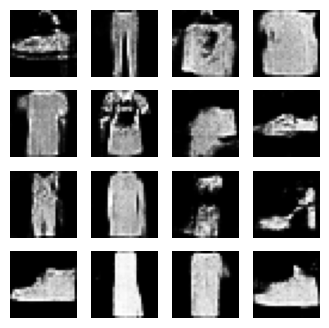

Time taken to process epoch 38 was  393.6848781108856 seconds


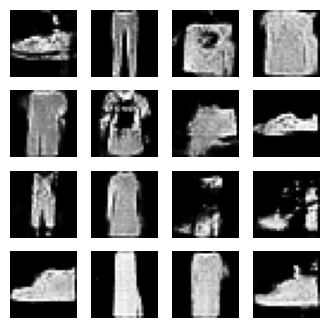

Time taken to process epoch 39 was  393.59903740882874 seconds


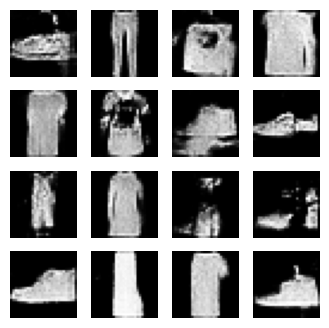

Time taken to process epoch 40 was  393.1483085155487 seconds


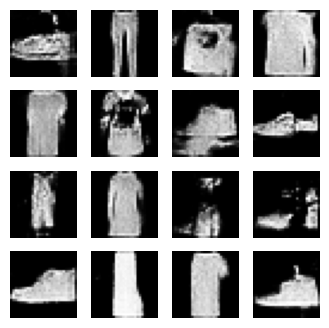

In [28]:
train(X_train, epochs)

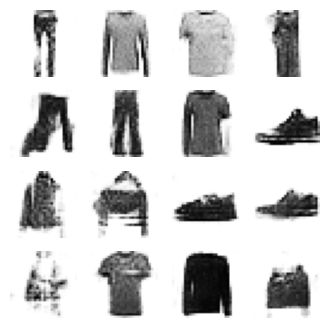

In [37]:
seed_input = tf.random.normal([number_of_images, noise_dim])
preds = generator(seed_input, training = False)
fig = plt.figure(figsize = (4,4))
for i in range(preds.shape[0]):
    plt.subplot(4,4, i+1)
    plt.imshow(preds[i, :, :, 0] * 127.5+127.5, cmap = 'gray_r')
    plt.axis('off')

In [36]:
def save_models(generator, discriminator, path_generator='w_gan_mnistfashion_generator_model.keras', path_discriminator='w_gan_mnistfashion_discriminator_model.keras'):

    # Save the generator model
    generator.save(path_generator)
    print(f"Generator model saved at {path_generator}")
    
    # Save the discriminator model
    discriminator.save(path_discriminator)
    print(f"Discriminator model saved at {path_discriminator}")

# Example usage: After training, save the models
save_models(generator, discriminator, path_generator='w_gan_mnistfashion_generator_final.keras', path_discriminator='w_gan_mnistfashion_discriminator_final.keras')

Generator model saved at w_gan_mnistfashion_generator_final.keras
Discriminator model saved at w_gan_mnistfashion_discriminator_final.keras
